In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import os

# functions

In [97]:
def get_path_holfuy(station, format=None):
    if format=='csv_2021':
        folder = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2021\\final_readings_ablation\\'
        filename = str(station)+'_abl_sum.csv'
        path = os.path.join(folder, filename)
        return path

    elif format=='standard_point':
        folder = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2020\\holfuy_manual_readings_2020\\'
        if station==1001 or station==1008:
            filename = 'findelen_intermediate.dat'
        elif station==1002 or station==1006 or station==1007:
            filename = 'rhone_intermediate.dat'
        elif station==1003:
            filename = 'plainemorte_intermediate.dat'

        path = os.path.join(folder, filename)
        return path


def get_path_clim(station):
    if station == 1008:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_fin_200.dat'
    elif station == 1001:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_fin_700.dat'
    elif station == 1003:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_plm_P6.dat'
    elif station == 1007:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_rho_P5.dat'
    elif station == 1002:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_rho_P6.dat'
    elif station == 1006:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\climatology\\point_mb_Aaron\\cumulative_rho_P8.dat'
    return path


def import_climatology(path):
    head = pd.read_csv(
        path, sep=';', skiprows=2, skipinitialspace=True,
        header=0, nrows=0, encoding='latin1').columns

    usecols = np.arange(len(head))
    colnames = head
    climatology = pd.read_csv(path,
                           skiprows=4, sep=' ', skipinitialspace=True,
                           usecols=usecols, header=None,
                           names=colnames, dtype={'date_s': str,
                                                  'date_f': str,
                                                  'date0': str,
                                                  'date1': str})
    climatology.columns = climatology.columns.str.rstrip()
    climatology.columns = climatology.columns.str.replace('# ', '')
    climatology = climatology.drop_duplicates()
    return climatology


def import_holfuy(fpath=None, station=None, year=None, ice_only=True, exclude_keywords=True, format=None):
    """

    Parameters
    ----------
    fpath
    ice_only
    exclude_keywords
    format: standard: original format from johannes

    Returns
    -------

    """
    if not fpath:
        fpath = get_path_holfuy(station, format)
    if format=='standard_csv':
        cread = pd.read_csv(fpath, index_col=None, parse_dates=[0])

        # exclude some of the critical days
        if exclude_keywords:
            cread = cread[~cread.key_remarks.str.contains("SETUP", na=False)]
            # cread = cread[~cread.key_remarks.str.contains("REDRILL", na=False)]
            cread = cread[~cread.key_remarks.str.contains("TEARDOWN", na=False)]

        if ice_only:
            cread = cread[cread.phase == 'i']  # exclude snow

        return cread

    elif format=='standard_point':
        head = pd.read_csv(
            fpath, sep=';', skiprows=1, skipinitialspace=True,
            header=0, nrows=0, encoding='latin1').columns
        usecols = np.arange(len(head))
        colnames = head
        df = pd.read_csv(fpath,
                         skiprows=4, sep=' ', skipinitialspace=True,
                         usecols=usecols, header=None,
                         names=colnames, dtype={'date0': str,
                                                'date1': str})
        df.columns = df.columns.str.rstrip()
        df.columns = df.columns.str.replace('# ', '')
        df = df.drop_duplicates()
        # manual remove error in the glazioarch files
        try:
            if df.loc[269]['name']=='HF1008':
                df = df.drop(index=269)
        except:
            pass

        if not station:
            df = df[df['name'].str.contains('|'.join('HF'))]
        else:
            df = df[df['name'].str.contains('HF'+str(station))]
        selection = df[['date0', 'date1', 'mb_we']]

        date0 = [dt.datetime(int(x[0:4]), int(x[4:6]), int(x[6:])) for x in selection['date0'].values]
        date1 = [dt.datetime(int(x[0:4]), int(x[4:6]), int(x[6:])) for x in selection['date1'].values]
        selection = selection.assign(date0=date0)
        selection = selection.assign(date1=date1)

        selection = selection[['date0', 'date1', 'mb_we']]
        if year is not None:
            selection = selection[selection['date0'].dt.year == year]
        return selection

    elif format=='csv_2021':
        cread = pd.read_csv(fpath, index_col=None, parse_dates=[0], dayfirst=True)
        return cread
    elif format=='winter':
        cread = pd.read_excel(fpath, index_col=None)#, parse_dates=[0], dayfirst=True)
        return cread
    elif format=='mh_2021':
        #path_mh = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\2021\\holfuy_manual_readings_2021\\matthias\\fin1001_p700_holfuy2021.xlsx'
        holfuy_mh = pd.read_excel(fpath, index_col=None, skiprows=8, usecols=[0, 6], names=['date', 'mb[m.w.e]'])
        holfuy_mh = holfuy_mh.loc[holfuy_mh['date'].notnull()]
        holfuy_mh['mb[m.w.e]'] = holfuy_mh['mb[m.w.e]']/100
        return holfuy_mh
    else:
        return None
    
    
def interpolate_holfuy_df(df, mode=None):
    if mode is not None:
        time = np.arange(df['date'].values[0], df['date'].values[-1])
    else:
        time = np.arange(df['date'].values[0], df['date'].values[-1], dt.timedelta(days=1))
    not_yet_interpolated_holfuy = []
    for t in time:
        if t in df['date'].values:
            not_yet_interpolated_holfuy.append(df[df['date'] == t]['mb[m.w.e]'].values[0])
        else:
            not_yet_interpolated_holfuy.append(np.nan)

    interpolated_df = pd.DataFrame({'date': time, 'mb[m.w.e]': not_yet_interpolated_holfuy})
    if interpolated_df['mb[m.w.e]'].isnull().values.any():
        interpolated_df['mb[m.w.e]'] = interpolated_df['mb[m.w.e]'].interpolate(axis=0)
    return interpolated_df    


def get_mb_beg_year_to_holfuy_period(df, station, year):
    if year == 2021:
        return 0
    else:
        path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\mb_begin_holfuy_period.xlsx'
        mb_begin_df = pd.read_excel(path)
        indexes = mb_begin_df[(mb_begin_df['station']!=station) | (mb_begin_df['date'].dt.year!=year)].index
        # droping mutiple rows based on column value
        mb_begin_df = mb_begin_df.drop(indexes)
        date = mb_begin_df['date'].values[0]
        mb = mb_begin_df['mb[m.w.e]'].values[0]
        print(date, mb)
        shift = mb - df[df['date']==date]['mb[m.w.e]'].values[0]
        return shift

    
def get_date_last_meas(station, year):
    path = 'C:\\Users\\Aaron\\Documents\\pubblications\\paper1_anomalies\\data\\holfuy\\mb_begin_holfuy_period.xlsx'
    mb_begin_df = pd.read_excel(path)
    indexes = mb_begin_df[(mb_begin_df['station']!=station) | (mb_begin_df['date'].dt.year!=year)].index
    # droping mutiple rows based on column value
    mb_begin_df = mb_begin_df.drop(indexes)
    date = mb_begin_df['date_meas'].values[0]
    return date


def get_mb_last_meas_to_end(station, date):
    clim = import_climatology(get_path_clim(station))
    date = date.astype('datetime64[s]')
    date = date.astype(dt.datetime)
    clim = clim[clim['Hyd.year'] == date.year]
    mb_3009 = clim['balance(b)'].values[-1]
    clim = clim[clim['Month'] == date.month]
    clim = clim[clim['Day'] == date.day]
    mb_measure_day = clim['balance(b)'].values[0]

    mb_last_measure_to_end  = mb_3009 - mb_measure_day
    print(mb_last_measure_to_end)
    return mb_last_measure_to_end

    
def cut_clim_to_holfuy_period(clim_df, holfuy_df):
    first_date = np.min(holfuy_df['date'])
    last_date = np.max(holfuy_df['date'])
    indexes = clim_df[(clim_df['Month'] < first_date.month)
                        | (clim_df['Month'] == first_date.month) & (clim_df['Day'] < first_date.day)
                        | (clim_df['Month'] > last_date.month)
                        | (clim_df['Month'] == last_date.month) & (clim_df['Day'] > last_date.day)].index
    # droping mutiple rows based on column value
    clim_df = clim_df.drop(indexes)
    return clim_df


def get_bias(station, year, visualize=True):
    # holfuy
    if year == 2021:
        holfuy = import_holfuy(station=station, format='csv_2021')
        xtime_h = holfuy['date'].values
        rounded = xtime_h.astype('datetime64[s]')
        xtime_h = [x.astype(dt.datetime) for x in rounded]
        cum_mb = holfuy['mb[m.w.e]'].values
        holfuy_new = pd.DataFrame({'date': xtime_h, 'mb[m.w.e]': cum_mb})
    else:
        holfuy = import_holfuy(station=station, year=year, format='standard_point')
        xtime_h = holfuy['date1'].values
        cum_mb = np.cumsum(holfuy['mb_we'].values / 1000)
        holfuy_new = pd.DataFrame({'date': xtime_h, 'mb[m.w.e]': cum_mb})
    # clim
    xtime_c = pd.date_range(dt.datetime(year - 1, 10, 1), periods=366)
    if ((xtime_c.month == 2) & (xtime_c.day == 29)).any():
        pass
    else:
        xtime_c = xtime_c[:-1]

    clim = import_climatology(get_path_clim(station))
    clim = clim[clim['Hyd.year'] == year]
    date_last_measure = get_date_last_meas(station, year)
    mb_last_measure_to_end = get_mb_last_meas_to_end(station, date_last_measure)
    clim['balance(b)'] = clim['balance(b)'].values + mb_last_measure_to_end

    # interpolate holfuy data to have values every day
    interpolated_df = interpolate_holfuy_df(holfuy_new)
    mb_begin_season = get_mb_beg_year_to_holfuy_period(interpolated_df, station, year)
    interpolated_df['mb[m.w.e]'] = interpolated_df['mb[m.w.e]'].values + mb_begin_season
    
    # cut clim to match the length of holfuy data
    clim_cutted = cut_clim_to_holfuy_period(clim, interpolated_df)

    interpolated_df['mb[m.w.e]'] = interpolated_df['mb[m.w.e]'].values + \
                                    ((clim_cutted['balance(b)'].values[0] / 1000) - interpolated_df['mb[m.w.e]'].values[0])
    
    print(interpolated_df['mb[m.w.e]'].values)
    bias_y = interpolated_df['mb[m.w.e]'].values - clim_cutted['balance(b)'].values / 1000
    
    mean_bias_y = np.nanmean(bias_y)
    if visualize:
        fig, ax = plt.subplots(figsize=(10, 7))
        fig.text(0.25, 0.13, 'mean bias: ' + str(round(mean_bias_y, 3)) + ' m.w.e')
        ax.plot(interpolated_df['date'].values, interpolated_df['mb[m.w.e]'].values, label='holfuy', color='tab:blue')
        ax.scatter(interpolated_df['date'], interpolated_df['mb[m.w.e]'], marker='x', color='black', s=10)
        ax.plot(interpolated_df['date'].values, clim_cutted['balance(b)'].values / 1000, label='model', color='tab:orange')
        ax.plot(interpolated_df['date'].values, bias_y, label='bias', color='tab:red')
        ax.fill_between(interpolated_df['date'].values, bias_y, alpha=0.3, color='tab:red')
        plt.legend()
        plt.title('year ' + str(year) +', station ' + str(station))
        plt.suptitle('MODEL VS HOLFUY', fontweight="bold")
        plt.xlabel('Time')
        plt.ylabel('Mass Balance [m.w.e]')
        plt.show()
    return mean_bias_y


def get_bias_clim(station, year, visualize=True):
    if year == 2021:
        holfuy = import_holfuy(station=station, format='csv_2021')
        xtime_h = holfuy['date'].values
        rounded = xtime_h.astype('datetime64[s]')
        xtime_h = [x.astype(dt.datetime) for x in rounded]
        xtime_doy = [x.timetuple().tm_yday for x in xtime_h]  #
        cum_mb = holfuy['mb[m.w.e]'].values
        holfuy_new = pd.DataFrame({'date': xtime_doy, 'mb[m.w.e]': cum_mb})
    else:
        holfuy = import_holfuy(station=station, year=year, format='standard_point')
        xtime_h = holfuy['date1'].values
        rounded = xtime_h.astype('datetime64[s]')  #
        xtime_h = [x.astype(dt.datetime) for x in rounded]  #
        xtime_doy = [x.timetuple().tm_yday for x in xtime_h]  #
        cum_mb = np.cumsum(holfuy['mb_we'].values / 1000)
        holfuy_new = pd.DataFrame({'date': xtime_doy, 'mb[m.w.e]': cum_mb})
    # clim
    xtime_c = pd.date_range(dt.datetime(year - 1, 10, 1), periods=366)
    if ((xtime_c.month == 2) & (xtime_c.day == 29)).any():
        pass
    else:
        xtime_c = xtime_c[:-1]

    clim = import_climatology(get_path_clim(station))

    clim_std = clim.groupby(['DOY']).std().reset_index()  #
    clim = clim.groupby(['DOY']).mean().reset_index()  #
    interpolated_df = interpolate_holfuy_df(holfuy_new, mode='DOY')  #

    first_date = np.min(interpolated_df['date'])
    last_date = np.max(interpolated_df['date'])
    indexes = clim[(clim['DOY'] < first_date) | (clim['DOY'] > last_date)].index  #

    # droping mutiple rows based on column value
    clim_cutted = clim.drop(indexes)
    clim_std_cutted = clim_std.drop(indexes)

    bias_y = interpolated_df['mb[m.w.e]'].values - clim_cutted['balance(b)'].values / 1000

    if visualize:
        if bias_only:
            ax1.plot(clim_cutted['DOY'].values, bias_y,
                    label='bias' + 'Station : ' + str(station) + ' year : ' + str(year))
            ax1.fill_between(clim_cutted['DOY'].values, bias_y, alpha=0.2)
        else:
            fig, ax = plt.subplots(figsize=(10, 7))
            ax.plot(interpolated_df['date'].values, interpolated_df['mb[m.w.e]'].values, label='holfuy', color='tab:blue')
            ax.scatter(interpolated_df['date'].values, interpolated_df['mb[m.w.e]'].values, marker='x', color='black', s=10)
            ax.plot(clim_cutted['DOY'].values, clim_cutted['balance(b)'].values / 1000, label='climatology', color='tab:orange')
            ax.fill_between(clim_cutted['DOY'].values, (clim_cutted['balance(b)'].values - clim_std_cutted['balance(b)'].values)/ 1000 ,
                            (clim_cutted['balance(b)'].values + clim_std_cutted['balance(b)'].values)/ 1000 , color='tab:orange', alpha=0.1)

            ax.plot(clim_cutted['DOY'].values, bias_y, label='bias' + 'Station : ' + str(station)+ ' year : ' + str(year), color='tab:green')
            ax.fill_between(clim_cutted['DOY'].values, bias_y, color='tab:green', alpha=0.2)

            plt.title('year ' + str(year) + ', station ' + str(station))
            plt.suptitle('CLIMATOLOGY VS HOLFUY', fontweight="bold")
            plt.xlabel('Day of Year')
            plt.ylabel('Mass Balance [m.w.e]')
            plt.legend()
            plt.show()


# Main 1
    . get vertical bias between model and modelled year
    . plot bias between climatology and holfuy
    . compares all biases

2020-07-29T00:00:00.000000000 -0.78


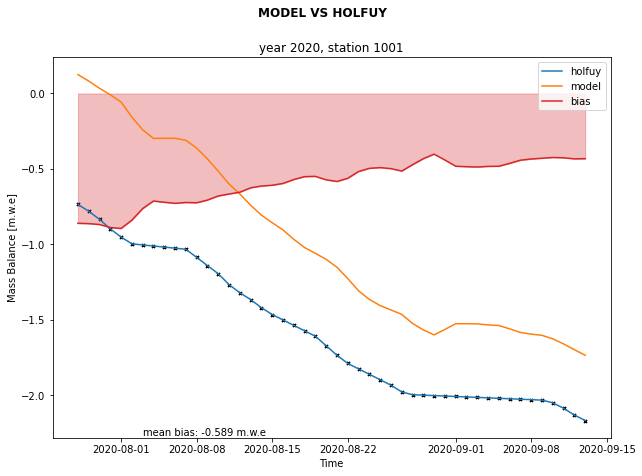

[-0.5891458333333336] -0.5891458333333336


In [53]:
bias_only= False
years = [2020]
# attention order of the paths resp stations must agre!!!
#paths = [path_climf2]#, path_climf7, path_climr5, path_climr6, path_climr8, path_climp6]
stations = [1001]#, 1001, 1007, 1002, 1006, 1003]
bias = []

if bias_only:
    fig1, ax1 = plt.subplots(figsize=(10, 7))

for station in stations:
    for year in years:
        if bias_only:
            get_bias_clim(station, year)
        else:
            #get_bias_clim(station, year)
            bias_y = get_bias(station, year, visualize=True)
            bias.append(bias_y)
    print(bias, np.mean(bias))
if bias_only:
    plt.xlabel('Day of Year')
    plt.ylabel('Mass Balance [m.w.e]')
    plt.legend()
    plt.show()

# Main 2

-250
[-0.918      -0.9366576  -0.95354056 -0.96701775 -0.98456959 -1.00887293
 -1.04165747 -1.0656713  -1.10162942 -1.15670144 -1.20273109 -1.24809735
 -1.2914335  -1.33604861 -1.38186586 -1.42480029 -1.51518032 -1.59883574
 -1.65460406 -1.71305632 -1.75112466 -1.78604138 -1.81151809 -1.86903436
 -1.92107968 -1.96894255 -2.03461826 -2.06505552 -2.08667165 -2.10202662
 -2.12023193 -2.15955808 -2.20971089 -2.24959122 -2.28821609 -2.31798684
 -2.38714766 -2.42340931 -2.46154595 -2.50414499 -2.52434317 -2.53547195
 -2.56372731 -2.60358313 -2.64093541 -2.66876618 -2.69557921 -2.72572608
 -2.76455455 -2.78422079 -2.78394463 -2.78422925 -2.78364273]


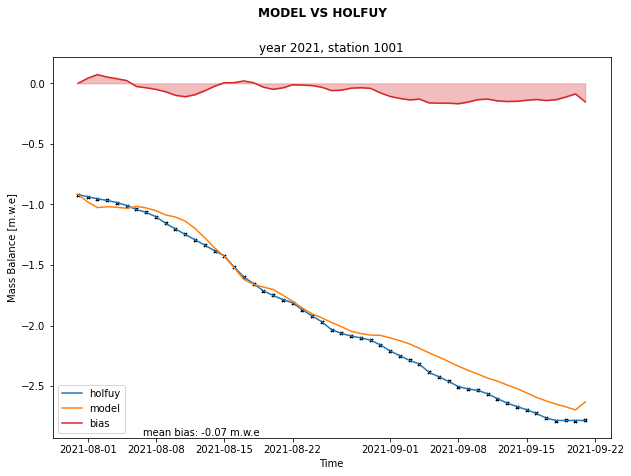

In [101]:
year = 2021
station = 1001

bias_y = get_bias(station, year, visualize=True)